In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tabulate import tabulate

from utils.exp import extract_H_T, read_train_val_test_loss, map_model_name
from constants import DATASETS, T_LIST

import matplotlib.font_manager as fm

# Define the font family name
font_family = "cmr10"

# Find the font file for the Computer Modern font
font_path = fm.findfont(fm.FontProperties(family=font_family))

# Set the default font family
plt.rcParams["font.family"] = font_family
plt.rcParams["font.sans-serif"] = [font_family]

In [2]:
x = np.array([[1,2]])
np.vstack([x, np.empty((2,2))])

array([[1.00000000e+000, 2.00000000e+000],
       [7.59037894e-311, 6.34264542e-311],
       [2.80740043e-311, 1.59361884e-311]])

In [3]:
def analyse(exp_dir: str ='exp_ori'):

    mean_test_mse_dfs = []
    models = ['nlinear-i', 'nlinear-ni', 'dlinear-i', 'dlinear-ni', 'tide-wo-a', 'tide-w-a', 'gcformer', 'fdnet']

    table_df_rows = [[None]*(2+len(models)) for _ in range((len(DATASETS)*len(T_LIST)))]

    for model_index, model in enumerate(models):
        table_df_column_index = 2 + model_index

        all_data_train_mse = []
        all_data_val_mse = []
        all_data_test_mse = []

        table_row_index = 0
        for data_index,data in enumerate(DATASETS):
            data_dir = os.path.join(exp_dir, model, data)

            h = []
            t = []
            val_mse = []
            train_mse = []
            test_mse = []

            for ht_dir_name in os.listdir(data_dir):
                ht_dir_path = os.path.join(data_dir, ht_dir_name)
                H,T = extract_H_T(ht_dir_name)

                train_losses, val_losses, test_loss = read_train_val_test_loss(ht_dir_path)

                h.append(H)
                t.append(T)
                val_mse.append(min(val_losses))
                train_mse.append(min(train_losses))
                test_mse.append(test_loss)

            all_data_train_mse.append(train_mse)
            all_data_val_mse.append(val_mse)
            all_data_test_mse.append(test_mse)

            df = pd.DataFrame({
                'H': h,
                'T': t,
                'train_mse': train_mse,
                'val_mse': val_mse,
                'test_mse': test_mse
            })

            df.sort_values(by='T')

            for T in T_LIST:
                table_df_rows[table_row_index][0] = data
                table_df_rows[table_row_index][1] = T
                table_df_rows[table_row_index][table_df_column_index] = "%.3f" % df[df['T'] == T]['test_mse'].mean()
                table_row_index += 1

            # for mse_col in ['train_mse', 'val_mse', 'test_mse']:
            #     sns.catplot(df, x='T', y=mse_col, hue='H', kind='bar', palette='rocket', height=3, aspect=3)
            #     plt.title(f'{model}, {data} - {mse_col[:-4]}')
            #     plt.show()

            print('*'*50)
                
        def cal_mean_of_datasets_by_same_config(all_mse_list: List[List[float]]):
            return list(map(np.mean, list(zip(*all_mse_list))))

        mean_train_mse = cal_mean_of_datasets_by_same_config(all_data_train_mse)
        mean_val_mse = cal_mean_of_datasets_by_same_config(all_data_val_mse)
        mean_test_mse = cal_mean_of_datasets_by_same_config(all_data_test_mse)

        df = pd.DataFrame({
            'H': h,
            'T': t,
            'train_mse': mean_train_mse,
            'val_mse': mean_val_mse,
            'test_mse': mean_test_mse
        })

        sns.catplot(df, x='T', y='test_mse', hue='H', kind='bar', palette='rocket', height=3, aspect=3)
        plt.title(f'{model}, mse of test datasets')
        plt.show()

        mean_test_mse_dfs.append(df)

    table_df = pd.DataFrame(table_df_rows)
    table_df.columns = ['dataset', 'T'] + models
    table_df.to_csv('result_table.csv', index=False, sep='&')

    
    # plot mean of mse of test datases of nlinear vs dlinear
    fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(10,6))

    for i,model in enumerate(models):
        r = i // 4
        c = i % 4
        model_df = mean_test_mse_dfs[i]
        sns.barplot(model_df, x='T', y='test_mse', hue='H', palette='rocket', ax=axes[r][c])
        axes[r][c].title.set_text(map_model_name(model))
        if c != 0:
            axes[r][c].set_ylabel('')
        axes[r][c].set_xlabel('')

    handles, labels = axes[1][1].get_legend_handles_labels()
    for i in range(len(models)):
        r = i // 4
        c = i % 4
        axes[r][c].legend_.remove()

    fig.legend(handles, labels, loc='upper right', title='H\n(history\nlength)')
    # fig.supxlabel('T - number of time steps to predict')
    
    # plt.suptitle('MSE of each T and H')
    plt.tight_layout()
    fig.subplots_adjust(right=0.9)
    plt.show()

    #########
    fig = plt.figure(figsize=(len(models),2))
    heights = []
    for i in range(len(models)):
        heights.append(mean_test_mse_dfs[i]['test_mse'].mean())
    rects = plt.bar(models, heights)    

    print(' & '.join(['%.3f' % e for e in heights]))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%.4f' % height,
                    ha='center', va='bottom')
            
    autolabel(rects)

    plt.xlabel('model')
    plt.ylabel('mse')
    plt.title('overall MSE', pad=20)
    plt.xticks(rotation=90)
    plt.show()


**************************************************
**************************************************
**************************************************


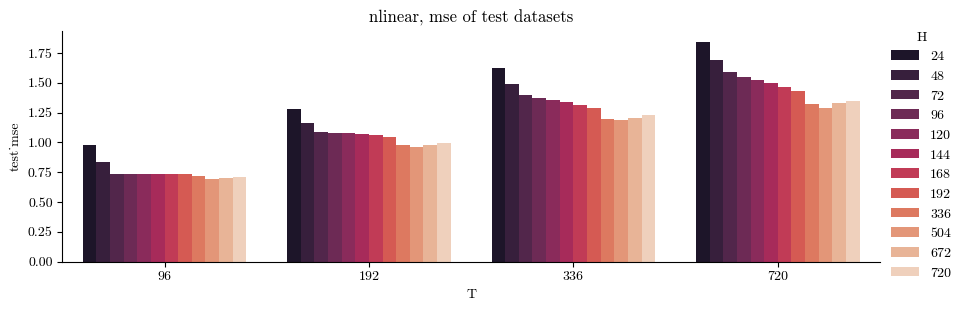

**************************************************
**************************************************
**************************************************


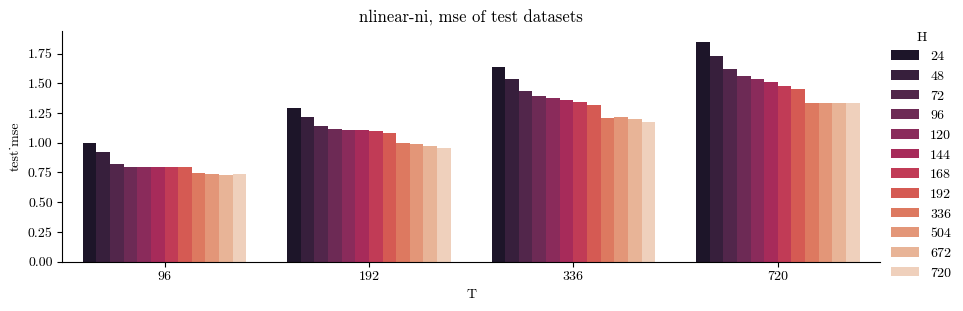

**************************************************
**************************************************
**************************************************


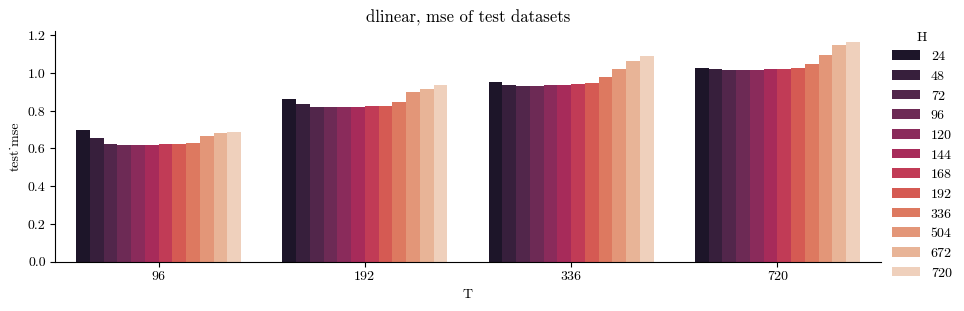

**************************************************
**************************************************
**************************************************


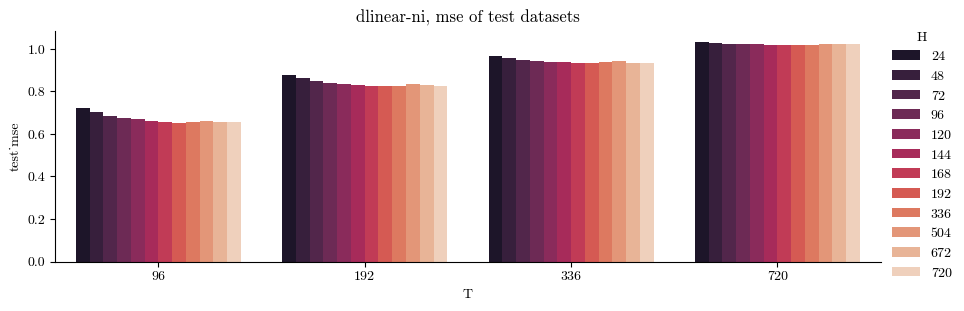

**************************************************
**************************************************
**************************************************


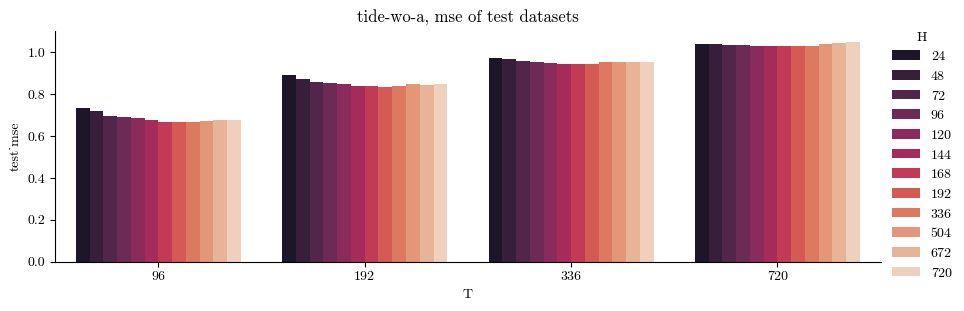

**************************************************
**************************************************
**************************************************


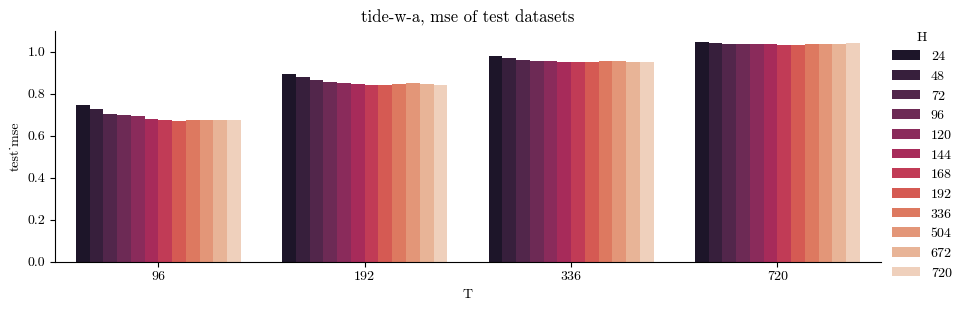

**************************************************
**************************************************
**************************************************


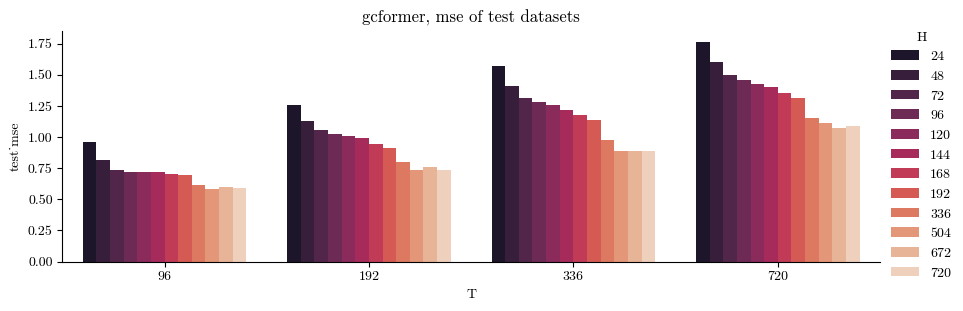

**************************************************
**************************************************
**************************************************


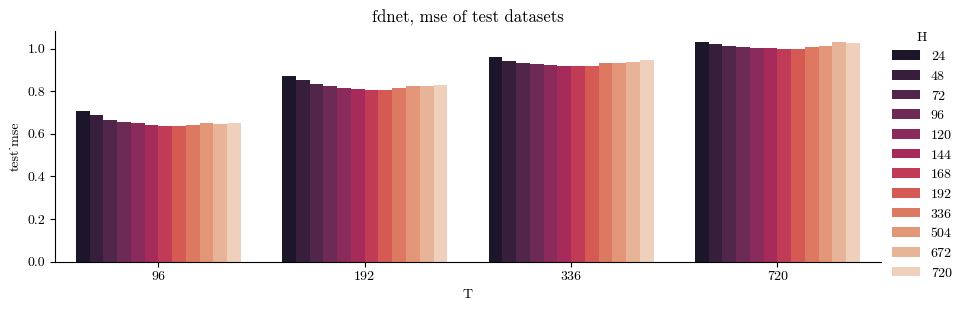

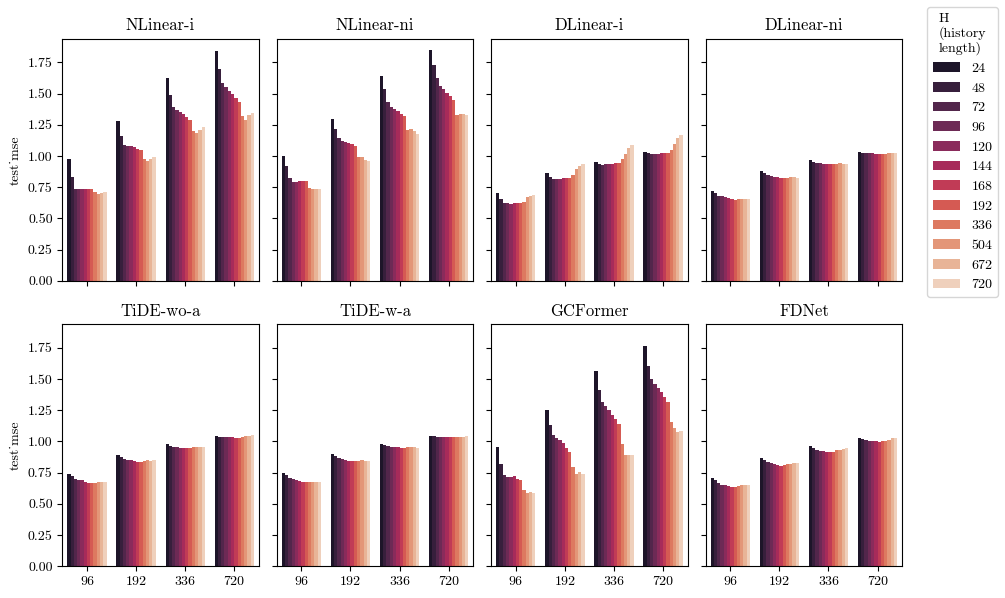

1.160 & 1.188 & 0.881 & 0.869 & 0.883 & 0.886 & 1.042 & 0.857


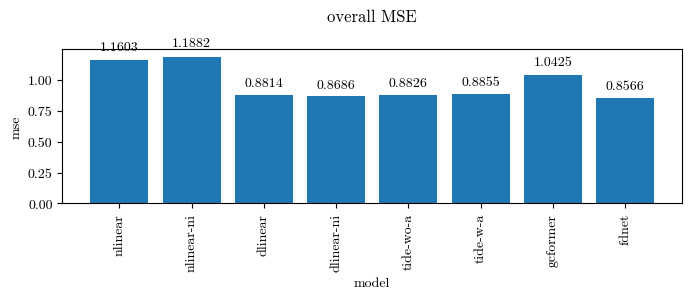

In [4]:
analyse()

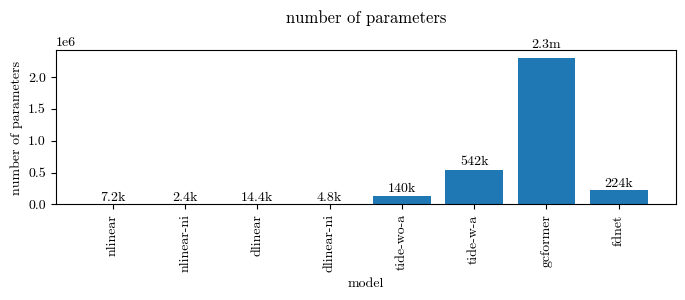

In [5]:
models = ['nlinear-i', 'nlinear-ni', 'dlinear-i', 'dlinear-ni', 'tide-wo-a', 'tide-w-a', 'gcformer', 'fdnet']

n_params = {
    'nlinear-i': (7.2*1e3, '7.2k'),
    'nlinear-ni': (2.4*1e3, '2.4k'),
    'dlinear-i': (14.4*1e3, '14.4k'),
    'dlinear-ni': (4.8*1e3, '4.8k'),
    'tide-wo-a': (140*1e3, '140k'),
    'tide-w-a': (542*1e3, '542k'),
    'gcformer': (2.3*1e6, '2.3m'),
    'fdnet': (224*1e3, '224k')
}

# models = sorted(models, key=lambda x: n_params[x][0])

fig = plt.figure(figsize=(len(models),2))
heights = []
for model in models:
    heights.append(n_params[model][0])
rects = plt.bar(models, heights)    
        
for i,rect in enumerate(rects):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            n_params[models[i]][1],
            ha='center', va='bottom')

plt.xlabel('model')
plt.ylabel('number of parameters')
plt.title('number of parameters', pad=20)
plt.xticks(rotation=90)
plt.show()

# all ine one

In [6]:
def analyse_all_in_one(exp_dir: str ='exp-aio'):

    mean_test_mse_dfs = []
    models = ['tide-w-a', 'tide-wo-a']

    for model in models:

        all_data_train_mse = []
        all_data_val_mse = []
        all_data_test_mse = []

        model_dir = os.path.join(exp_dir, model)
        for data in os.listdir(model_dir):
            data_dir = os.path.join(exp_dir, model, data)

            h = []
            t = []
            val_mse = []
            train_mse = []
            test_mse = []

            for ht_dir_name in os.listdir(data_dir):
                ht_dir_path = os.path.join(data_dir, ht_dir_name)
                H,T = extract_H_T(ht_dir_name)

                train_losses, val_losses, test_loss = read_train_val_test_loss(ht_dir_path)

                h.append(H)
                t.append(T)
                val_mse.append(min(val_losses))
                train_mse.append(min(train_losses))
                test_mse.append(test_loss)

            all_data_train_mse.append(train_mse)
            all_data_val_mse.append(val_mse)
            all_data_test_mse.append(test_mse)

            df = pd.DataFrame({
                'H': h,
                'T': t,
                'train_mse': train_mse,
                'val_mse': val_mse,
                'test_mse': test_mse
            })

            df.sort_values(by='T')

            # for mse_col in ['train_mse', 'val_mse', 'test_mse']:
            #     sns.catplot(df, x='T', y=mse_col, hue='H', kind='bar', palette='rocket', height=3, aspect=3)
            #     plt.title(f'{model}, {data} - {mse_col[:-4]}')
            #     plt.show()

            print('*'*50)
                
        def cal_mean_of_datasets_by_same_config(all_mse_list: List[List[float]]):
            return list(map(np.mean, list(zip(*all_mse_list))))

        mean_train_mse = cal_mean_of_datasets_by_same_config(all_data_train_mse)
        mean_val_mse = cal_mean_of_datasets_by_same_config(all_data_val_mse)
        mean_test_mse = cal_mean_of_datasets_by_same_config(all_data_test_mse)

        df = pd.DataFrame({
            'H': h,
            'T': t,
            'train_mse': mean_train_mse,
            'val_mse': mean_val_mse,
            'test_mse': mean_test_mse
        })

        sns.catplot(df, x='T', y='test_mse', hue='H', kind='bar', palette='rocket', height=3, aspect=3)
        plt.title(f'{model}, mse of test datasets')
        plt.show()

        mean_test_mse_dfs.append(df)

    
    # plot mean of mse of test datases of nlinear vs dlinear
    fig, axes = plt.subplots(nrows=1, ncols=len(models), sharey=True, sharex=True, figsize=(20,6))

    for i,model in enumerate(models):
        sns.barplot(mean_test_mse_dfs[i], x='T', y='test_mse', hue='H', palette='rocket', ax=axes[i])
        axes[i].title.set_text(model)
        if i != 0:
            axes[i].set_ylabel('')
        axes[i].set_xlabel('')

    handles, labels = axes[1].get_legend_handles_labels()
    for i in range(len(models)):
        axes[i].legend_.remove()

    fig.legend(handles, labels, loc='upper right', title='H\n(history\nlength)')
    fig.supxlabel('T - number of time steps to predict')
    
    plt.suptitle('MSE of each T and H')
    plt.tight_layout()
    fig.subplots_adjust(right=0.95)
    plt.show()

    #########
    fig = plt.figure(figsize=(len(models),2))
    heights = []
    for i in range(len(models)):
        heights.append(mean_test_mse_dfs[i]['test_mse'].mean())
    rects = plt.bar(models, heights)    

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%.4f' % height,
                    ha='center', va='bottom')
            
    autolabel(rects)

    plt.xlabel('model')
    plt.ylabel('mse')
    plt.title('overall MSE', pad=20)
    plt.xticks(rotation=90)
    plt.show()


**************************************************


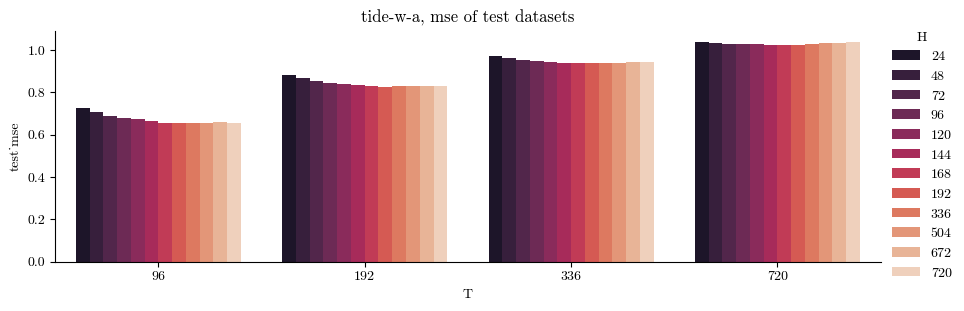

**************************************************


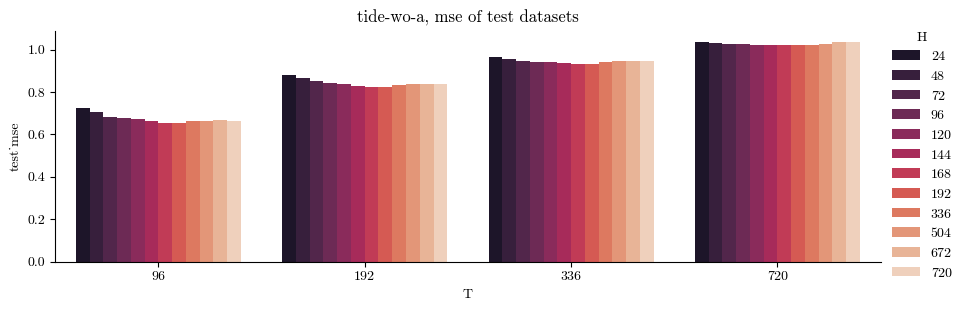

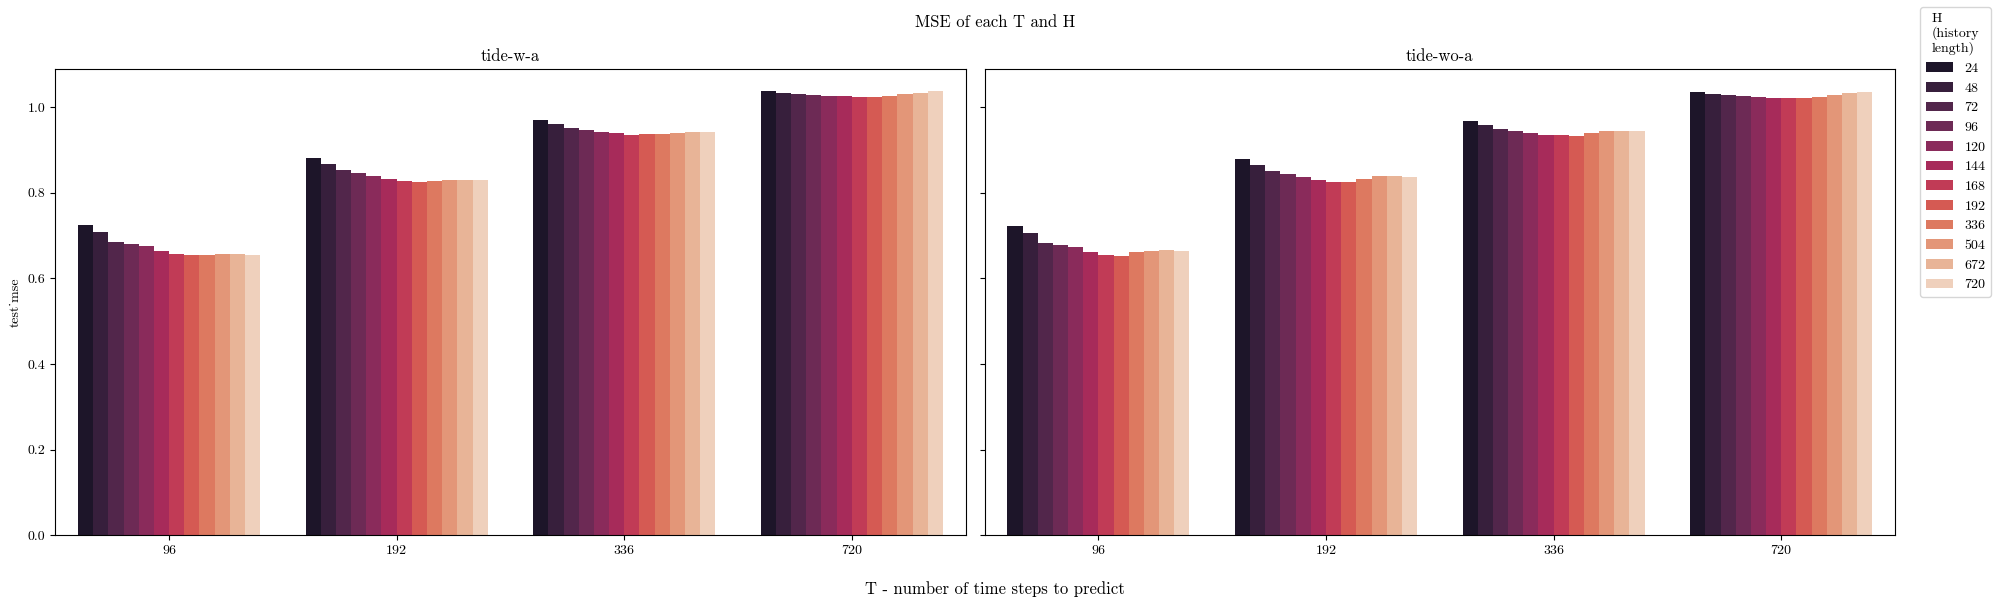

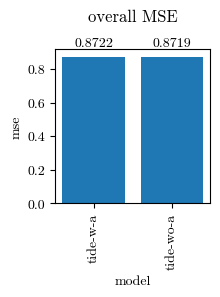

In [7]:
analyse_all_in_one()